### Importing Libraries 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import random

In [5]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import tensorflow as tf 
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

In [6]:
from numpy import unravel_index
import os

### Taking input of 75 image for each alphabet   

In [7]:
data = pd.read_csv("D:/Aplhabet Recognition/archive/A_Z Handwritten Data.csv")

###### data_div[i] will store i<sup>th</sup> alphabet  

In [8]:
data_div = [0 for i in range(26)]

In [9]:
%%time 
grouped = data.groupby(data['0'])
for i in range(26) :
    data_div[i] = grouped.get_group(i)

Wall time: 5.2 s


#### Splitting data into X(feature matrix) and y(output value)  

In [10]:
%%time 

y_div = [0 for i in range(26)] 
for i in range(26) :
    data_div[i] = data_div[i].sample(n = 75)
    y_div[i] = data_div[i]['0']
    del data_div[i]['0']

Wall time: 893 ms


### Now we'll use data augmentation to create 150 images of each alphabet 

In [11]:
def get_idg() :
    idg = ImageDataGenerator(
    rotation_range=random.randint(0,10),
    zoom_range = random.uniform(0,0.5), 
    fill_mode='constant', cval=255
    )
    
    return idg 

def get_idg_no() :
    idg = ImageDataGenerator(
    rotation_range= 0 
    )
    
    return idg

In [12]:
%%time

image_data_aug  = [0 for i in range(26)] 
y_data_aug = [0 for i in range(26)] 

for i in range(26) :
    a ,ya = get_idg_no().flow(data_div[i].values.reshape(len(data_div[i]),28,28,1), y_div[i],batch_size=75).next()
    b , yb = get_idg().flow(data_div[i].values.reshape(len(data_div[i]),28,28,1), y_div[i],batch_size=75).next()
    #print(a.shape)
    a = a.reshape(75,28*28)
    b = b.reshape(75,28*28)
    a = pd.DataFrame(a)
    b = pd.DataFrame(b)
    ya = pd.DataFrame(ya)
    yb = pd.DataFrame(yb)
    #print(a)
    aug_2 = (a,b)
    y_data_aug[i] = [y_div[i] for j in range(2)]
    #print(aug_4_y)
    image_data_aug[i] =  pd.concat(aug_2, ignore_index = True)
    y_data_aug[i] = pd.concat(y_data_aug[i]  ,ignore_index = True)
    #print(y_data_aug[i])
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
Wall time: 740 ms


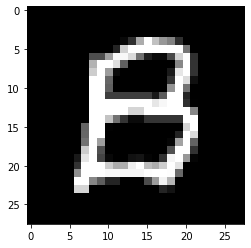

In [13]:
i_plot = image_data_aug[1].loc[1,:]
i_plot = np.array(i_plot)
plt.imshow(i_plot.reshape(28,28),cmap = 'gray')

### Training and Saving my Model  

In [14]:
pd_data = [0 for i in range(26)]
y_data = [0 for i in range(26)]

for i in range(26) :
    pd_data[i] = image_data_aug[i]
    y_data[i]  = y_data_aug[i]

In [15]:
X = pd.concat(pd_data)
y = pd.concat(y_data)

In [16]:
X = np.array(X)
y = np.array(y)

In [17]:
"""
Splitting data into train and test 
"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, shuffle=True)

In [18]:
X_train = X_train.reshape(-1,28,28,1)

X_test = X = X_test.reshape(-1,28,28,1)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [19]:
def my_model(width,height,channel) :
    model = Sequential()
    
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (width,height,channel)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.20))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.20)) 
    
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.20)) 
    
    
    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(26, activation = "softmax"))
    
    
    return model

In [20]:
model = my_model(28,28,1)

In [21]:
%%time 

model.compile(optimizer='adamax', loss = 'categorical_crossentropy', metrics=['accuracy'])

Wall time: 45.5 ms


In [22]:
checkpoint_path = "my_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

### Note

<h5> The Hyperparameters we are using in training the model are tuned after checking with various values </h5>

In [23]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=64, shuffle=True,callbacks=[cp_callback])

Epoch 1/25
49/49 [==============================] - 18s 349ms/step - loss: 3.4798 - accuracy: 0.1477 - val_loss: 2.7428 - val_accuracy: 0.1885

Epoch 00001: saving model to my_model.ckpt
Epoch 2/25
49/49 [==============================] - 15s 305ms/step - loss: 1.4736 - accuracy: 0.5454 - val_loss: 1.6966 - val_accuracy: 0.5897

Epoch 00002: saving model to my_model.ckpt
Epoch 3/25
49/49 [==============================] - 13s 265ms/step - loss: 0.8551 - accuracy: 0.7387 - val_loss: 1.0345 - val_accuracy: 0.7590

Epoch 00003: saving model to my_model.ckpt
Epoch 4/25
49/49 [==============================] - 15s 302ms/step - loss: 0.5682 - accuracy: 0.8265 - val_loss: 0.6138 - val_accuracy: 0.8308

Epoch 00004: saving model to my_model.ckpt
Epoch 5/25
49/49 [==============================] - 13s 268ms/step - loss: 0.4283 - accuracy: 0.8677 - val_loss: 0.3826 - val_accuracy: 0.8974

Epoch 00005: saving model to my_model.ckpt
Epoch 6/25
49/49 [==============================] - 13s 274ms/ste

### Plotting Loss and Accuracy vs Epoch  

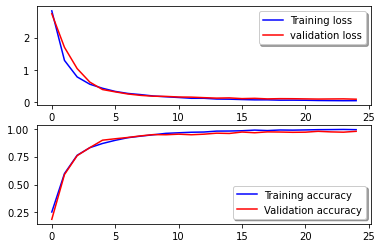

In [24]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

##### Predicting Class  

In [29]:
model.predict_classes(X_test[:1]) , np.argmax(y_test[:1])

(array([7], dtype=int64), 7)

In [35]:
np.round(model.predict(X_test[:2]),0) , y_test[:2]

(array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32))

###### Evaluting Model  

In [30]:
model.evaluate(X_test , y_test)

25/25 [==============================] - 1s 21ms/step - loss: 0.0817 - accuracy: 0.9769


[0.08171017467975616, 0.9769230484962463]

###  Calculating recall , accuracy , precision and f1 score  

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [34]:
accuracy = model.evaluate(X_test, y_test)[1]
print(accuracy)

25/25 [==============================] - 1s 20ms/step - loss: 0.0817 - accuracy: 0.9769
0.9769230484962463


In [36]:
y_pred = np.round(model.predict(X_test),0) 
y_actual = y_test

In [41]:
accuracy 

0.9769230484962463

In [38]:
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      0.93      0.97        30
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        30
           4       0.97      1.00      0.98        30
           5       1.00      0.97      0.98        30
           6       1.00      1.00      1.00        30
           7       0.94      1.00      0.97        30
           8       0.94      1.00      0.97        30
           9       1.00      0.97      0.98        30
          10       0.93      0.90      0.92        30
          11       1.00      1.00      1.00        30
          12       1.00      1.00      1.00        30
          13       0.97      1.00      0.98        30
          14       0.91      1.00      0.95        30
          15       1.00      0.97      0.98        30
          16       0.97      0.97      0.97        30
          17       1.00    

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
